# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Kangho Ji
- Victoria Charry
- Shiv Patel
- Pranav Guntupalli

In [16]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
# Function to clean the FDA dataset
def clean_data(df):
    """
    Cleans the dataframe by performing various transformations and removing invalid data.
    
    Args:
        df (pd.DataFrame): DataFrame containing the raw FDA data.
    
    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    # Convert age and sex to numeric
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['sex'] = pd.to_numeric(df['sex'], errors='coerce')
    
    # Replace sex codes with labels
    df['sex'] = df['sex'].replace({0: 'Unknown', 1: 'Male', 2: 'Female'})
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Count number of reactions (our target variable)
    df['reaction_count'] = df['reaction'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Remove rows with missing critical values
    required_columns = ['age', 'sex', 'drug', 'reaction_count']
    df.dropna(subset=required_columns, inplace=True)
    
    # Remove unrealistic ages
    df = df[(df['age'] > 0) & (df['age'] < 120)]
    
    # Remove rows with zero reactions
    df = df[df['reaction_count'] > 0]
    
    return df

# Collect FDA data
url = "https://api.fda.gov/drug/event.json"
drugs = ["OXYCODONE", "HYDROCODONE", "FENTANYL", "ALPRAZOLAM", "AMPHETAMINE"]

all_data = []

for drug in drugs:
    params = {"search": f"patient.drug.medicinalproduct:{drug}", "limit": 1000}
    response = requests.get(url, params=params)
    
    results = response.json().get("results", [])
    
    for record in results:
        patient = record.get("patient", {})
        reactions = patient.get("reaction", [])
        reaction_text = ", ".join([r.get("reactionmeddrapt", "") for r in reactions])
        
        all_data.append({
            "drug": drug,
            "age": patient.get("patientonsetage"),
            "sex": patient.get("patientsex"),
            "reaction": reaction_text,
            "serious": record.get("serious"),
            "date": record.get("receivedate")
        })

# Create and clean DataFrame
df = pd.DataFrame(all_data)
df = clean_data(df)

# Save cleaned data
fda_csv_path = 'fda_cleaned_data.csv'
df.to_csv(fda_csv_path, index=False)
print(f"\nCleaned data saved. Total records: {len(df)}")


Cleaned data saved. Total records: 3963


In [20]:
# Print first 50 rows of cleaned FDA CSV
if fda_csv_path:
    print(f"Head of cleaned FDA data ({fda_csv_path}):")
    print(pd.read_csv(fda_csv_path).head())
else:
    print("\nNo cleaned FDA data available.")

Head of cleaned FDA data (fda_cleaned_data.csv):
        drug   age     sex                                           reaction  \
0  OXYCODONE  63.0  Female  Loss of consciousness, Fall, Gait disturbance,...   
1  OXYCODONE  70.0    Male                      Nephrogenic systemic fibrosis   
2  OXYCODONE  53.0  Female  Hyponatraemia, Dyspnoea, Pyrexia, Pancreatitis...   
3  OXYCODONE  68.0  Female                  Nausea, Drug administration error   
4  OXYCODONE  71.0    Male                                              Death   

   serious        date  reaction_count  
0        1  2014-03-12               7  
1        1  2014-03-12               1  
2        1  2014-03-12               7  
3        2  2014-03-12               2  
4        1  2014-03-12               1  


## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np
from sklearn.preprocessing import StandardScaler

In [23]:
# Function to preprocess for modeling
def preprocess_data(df):
    """
    Preprocess the data by creating features needed for ML.
    
    Args:
        df (pd.DataFrame): cleaned dataframe
    
    Returns:
        pd.DataFrame: preprocessed dataframe
    """
    # Ensure numeric columns
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['reaction_count'] = pd.to_numeric(df['reaction_count'], errors='coerce')
    
    # Create numeric gender variable
    df['sex_numeric'] = df['sex'].map({'Male': 1, 'Female': 2, 'Unknown': 0})
    
    # Drop NaN
    df.dropna(subset=['age', 'sex_numeric', 'reaction_count'], inplace=True)
    
    return df

### Attempt 1 - Linear Regression

In [24]:
# Function to fit and evaluate the model
def evaluate_model(X, y, title):
    """
    Fit a linear regression model and check assumptions with diagnostic plots.
    
    Args:
        X (array): array with x feature values
        y (array): array with y values
        title (str): title of the model for the graph
    
    Returns:
        An evaluated model for the given feature along with the plots
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {round(mse, 3)}")
    r2 = r2_score(y_test, y_pred)
    print(f"{title} - R²: {round(r2, 4)}")
    
    # Residuals
    residuals = y_test - y_pred
    
    # Diagnostic Plots
    plt.figure(figsize=(16, 12))

    # 1. Residuals vs Fitted (Linearity/Constant Variance)
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    
    # 2. Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(X_test)), residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Order")
        
    # 3. Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    
    # 4. Histogram of Residuals (Normality)
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

Model 1: Age
Model 1: Age - Mean Squared Error: 46.488
Model 1: Age - R²: 0.0007


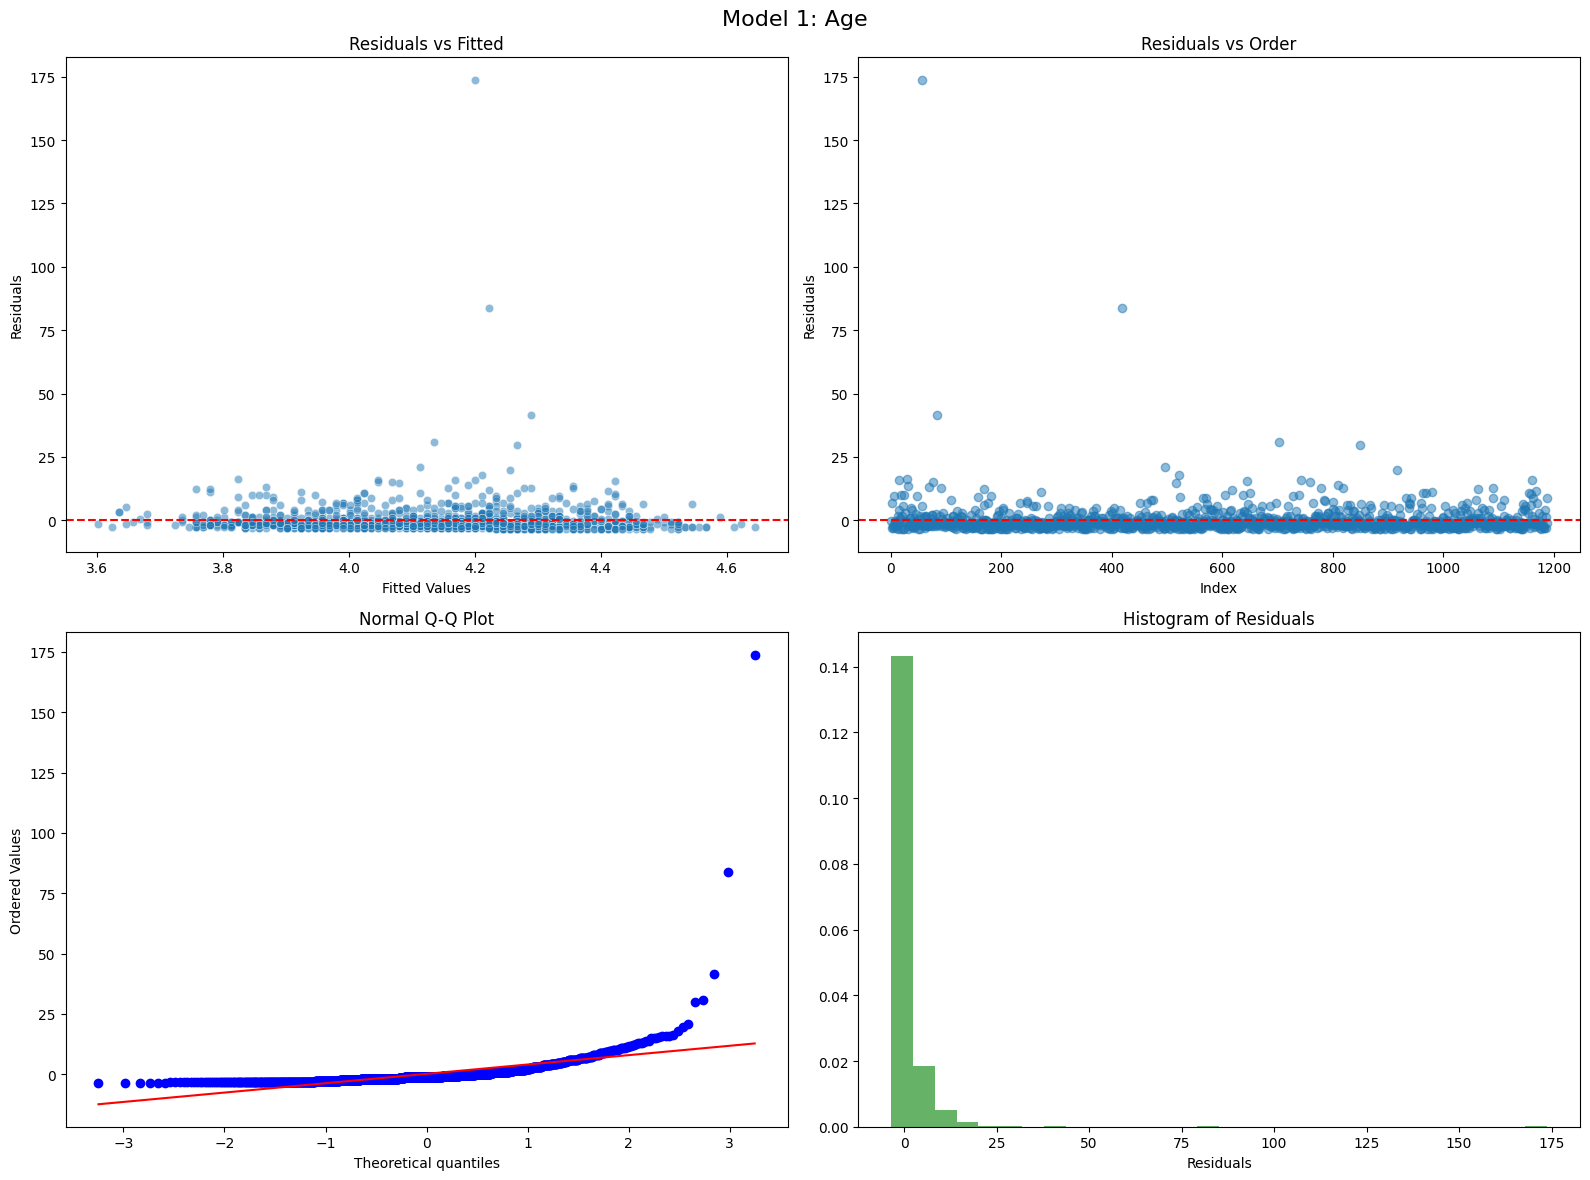


Model 2: Gender
Model 2: Gender - Mean Squared Error: 46.602
Model 2: Gender - R²: -0.0018


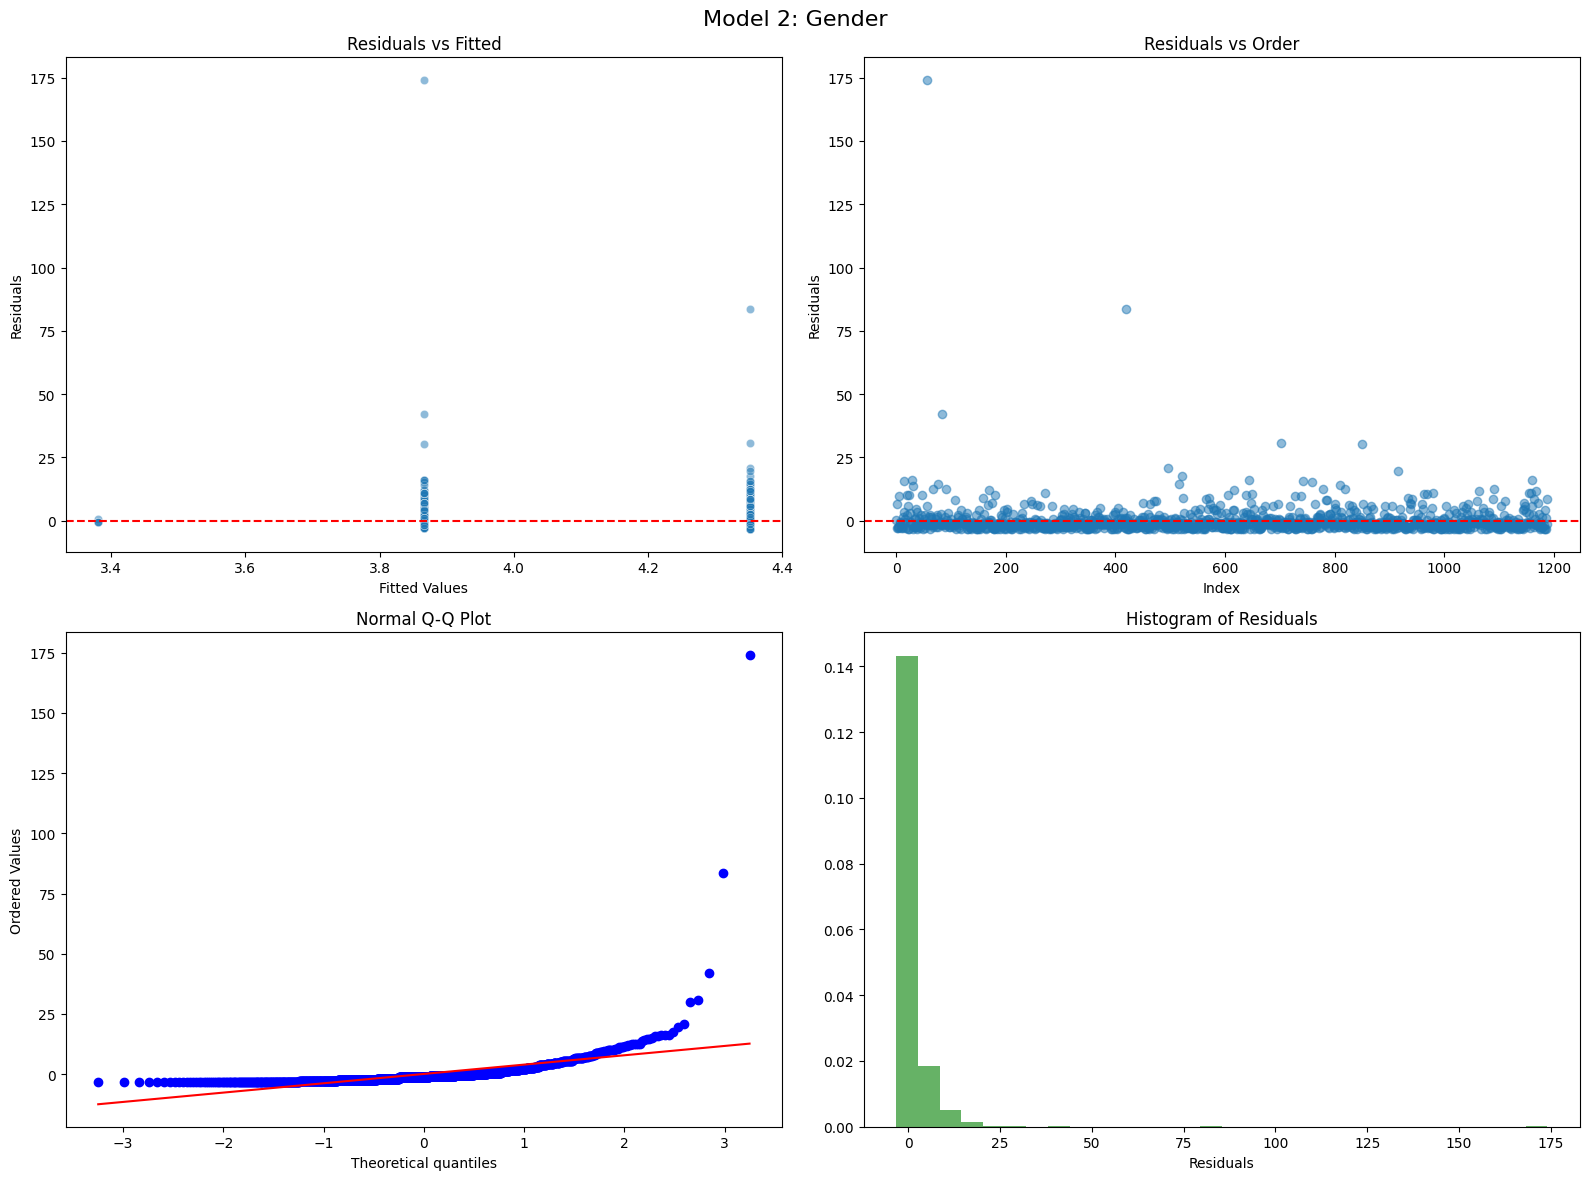


Model 3: Drug Type
Model 3: Drug Type - Mean Squared Error: 46.512
Model 3: Drug Type - R²: 0.0001


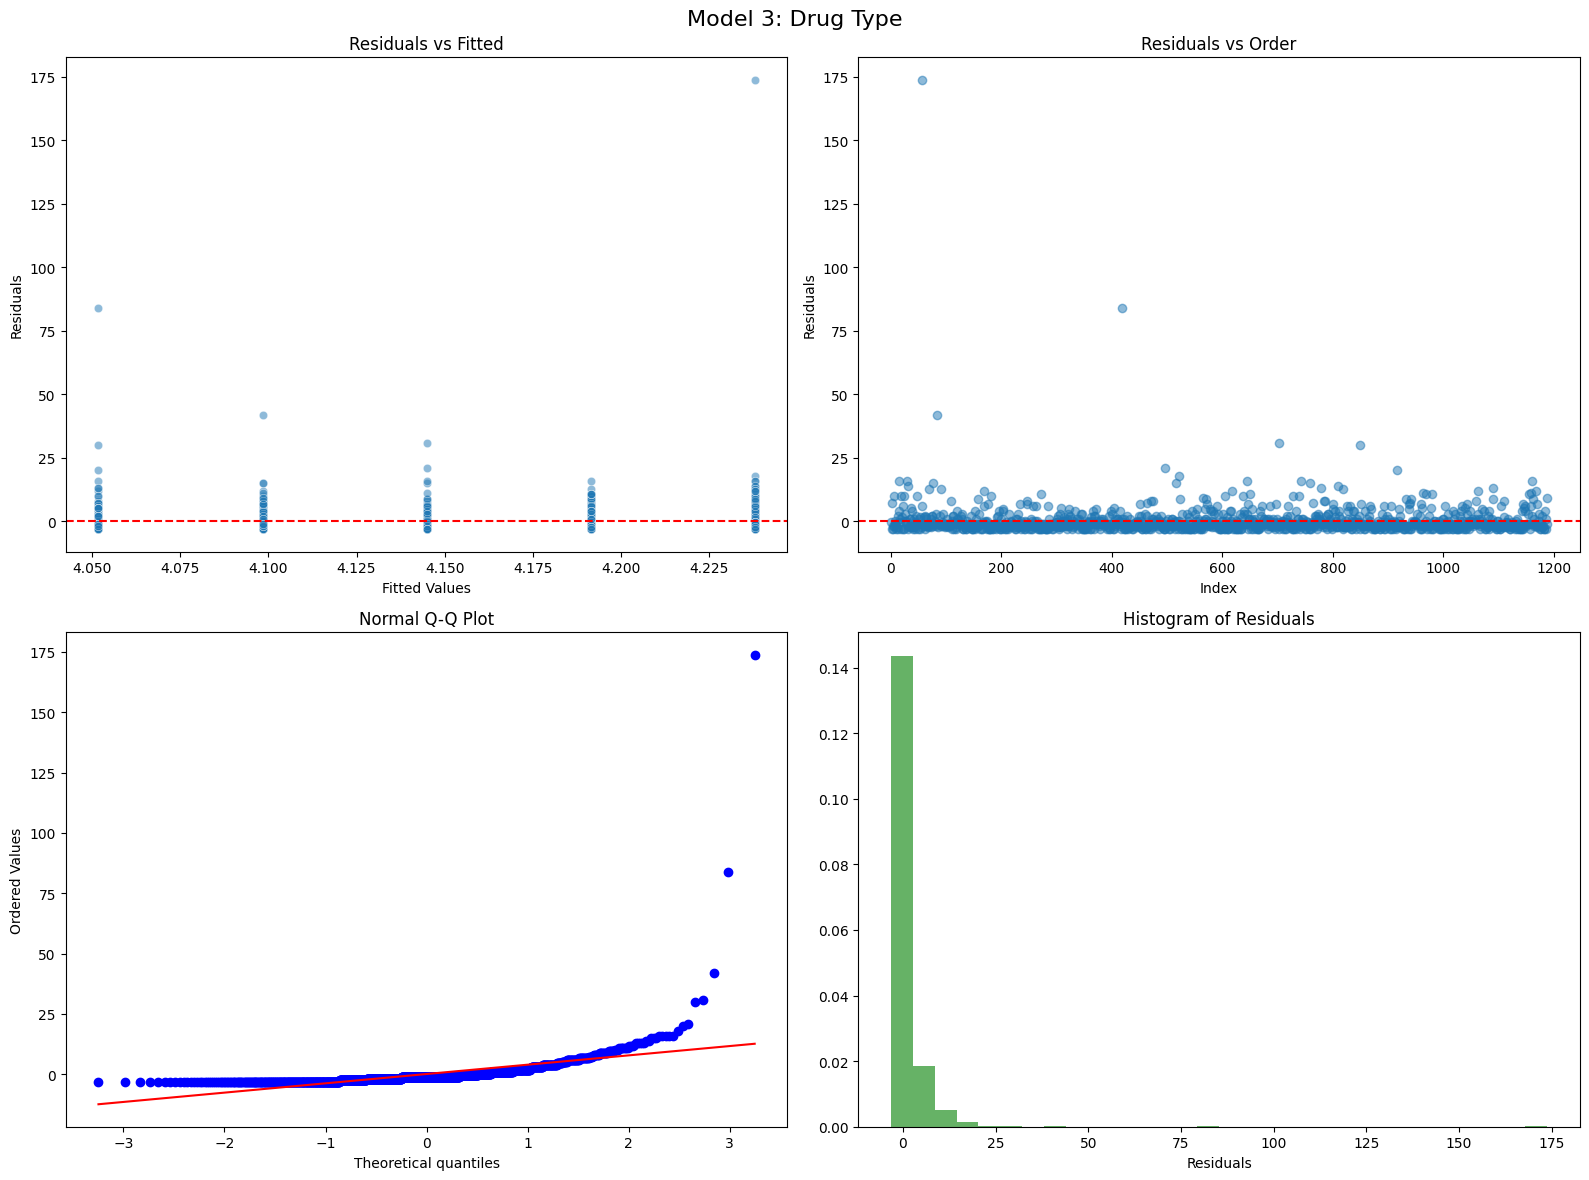

In [25]:
# Main function
def main():
    """
    Run all three linear regression models
    """
    try:
        df = pd.read_csv(fda_csv_path)
        df = preprocess_data(df)
        
        # Model 1: Age
        print("Model 1: Age")
        X_age = df[['age']].values
        y = df['reaction_count'].values
        evaluate_model(X_age, y, "Model 1: Age")
        
        # Model 2: Gender
        print("\nModel 2: Gender")
        X_gender = df[['sex_numeric']].values
        y = df['reaction_count'].values
        evaluate_model(X_gender, y, "Model 2: Gender")
        
        # Model 3: Drug Type
        print("\nModel 3: Drug Type")
        df['drug_numeric'] = df['drug'].astype('category').cat.codes
        X_drug = df[['drug_numeric']].values
        y = df['reaction_count'].values
        evaluate_model(X_drug, y, "Model 3: Drug Type")
        
    except FileNotFoundError:
        print(f"File not found: {fda_csv_path}")

# Run the main function
if __name__ == '__main__':
    main()

### Attempt 2 - Polynomial Regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `age` ($x$) feature into an array (`X_age_poly`) that includes columns corresponding to building a quartic model for `reaction_count` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [26]:
# Preprocess the dataframe first
df = pd.read_csv(fda_csv_path)
df = preprocess_data(df)
df.head()

,drug,age,sex,reaction,serious,date,reaction_count,sex_numeric
0,OXYCODONE,63.0,Female,"Loss of consciousness, Fall, Gait disturbance,...",1,2014-03-12,7,2
1,OXYCODONE,70.0,Male,Nephrogenic systemic fibrosis,1,2014-03-12,1,1
2,OXYCODONE,53.0,Female,"Hyponatraemia, Dyspnoea, Pyrexia, Pancreatitis...",1,2014-03-12,7,2
3,OXYCODONE,68.0,Female,"Nausea, Drug administration error",2,2014-03-12,2,2
4,OXYCODONE,71.0,Male,Death,1,2014-03-12,1,1


In [27]:
from sklearn.preprocessing import PolynomialFeatures
# Prepare the data
X_age = np.array(df['age']).reshape(-1, 1)
y = df['reaction_count'].values

In [28]:
# Degree 4 for the quartic equation
poly = PolynomialFeatures(degree=4)
# Gets the X_poly with bias column in the beginning
X_poly_bias = poly.fit_transform(X_age)
# Removes the bias column
X_poly = X_poly_bias[:, 1:]
print(X_poly[0])

[6.3000000e+01 3.9690000e+03 2.5004700e+05 1.5752961e+07]


#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from above and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function. 

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [29]:
def add_bias_column(X):
    """Adds a bias column
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")
    return Xnew

In [30]:
def line_of_best_fit(X, y):
    """Returns a vector containing the coefficients for the line of best fit, including an intercept term
    Args:
        X (array): either 1-d or 2-d which includes all the predictor values, not including bias term
        y (array): a 1-d array which includes all corresponding response values to X
        
    Returns:
        m (array): the vector containing the coefficients for the line of best fit, including an intercept term
    """
    # Adds a bias column to X
    X_new = add_bias_column(X)
    # Calculates the line of best fit
    XtXinv = np.linalg.inv(np.matmul(X_new.T, X_new))
    m = np.matmul(XtXinv, np.matmul(X_new.T, y))
    return m

In [31]:
from sklearn.metrics import r2_score

In [33]:
def linreg_predict(Xnew, ynew, m):
    """Returns a dictionary containing: the predicted values from applying m to Xnew, the residuals, 
    the mean squared error, and the coefficient of determination
    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (array): a 1-d array which contains the coefficients from the line_of_best_fit function
    Returns:
        output_dict (dictionary): a dictionary that has:
            - 'ypreds' (the predicted values from applying m to Xnew)
            - 'resids' (the residuals, the differences between ynew and ypreds)
            - 'mse' (the mean squared error)
            - 'r2' (the coefficient of determination)
    """
    # Initializes an output dictionary for required values
    output_dict = {}
    # Adds a bias column to the Xnew array
    Xnew_bias_added = add_bias_column(Xnew)
    # Gets the predicted values from applying m to Xnew
    ypreds = np.matmul(Xnew_bias_added, m)
    # Gets the residuals
    res = ynew - ypreds
    # Gets the mean squared error
    mse = (res**2).mean()
    # Gets the R²
    r2 = 1 - (mse / ynew.var())
    # Adds values to the dictionary
    output_dict['ypreds'] = ypreds
    output_dict['resids'] = res
    output_dict['mse'] = mse
    output_dict['r2'] = r2
    return output_dict

In [34]:
# Single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# Finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# Prints out MSE and R² values
print('MSE for the polynomial regression model =', round(model['mse'], 3))
print('R² for the polynomial regression model =', round(model['r2'], 4))

MSE for the polynomial regression model = 46.371
R² for the polynomial regression model = 0.0032


### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables

#### Creating Fitting Model

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_1^3 + \beta_4 x_1^4 + \beta_5x_1x_2 + \beta_6x_1x_3 + \beta_7x_1x_4 + \beta_8x_1x_5 + \beta_9x_1x_6
$$

Where:
- $y$: reaction count
- $x_1$: age
- $x_2$: gender (Male = 1, Female = 0)
- $x_3$: HYDROCODONE (1 or 0)
- $x_4$: FENTANYL (1 or 0)
- $x_5$: ALPRAZOLAM (1 or 0)
- $x_6$: AMPHETAMINE (1 or 0)
- Polynomial terms: $\beta_0 + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_1^3 + \beta_4 x_1^4$
- Interaction terms with dummy variables: $\beta_5x_1x_2 + \beta_6x_1x_3 + \beta_7x_1x_4 + \beta_8x_1x_5 + \beta_9x_1x_6$

In [35]:
# Prepare the data
X_age = np.array(df['age']).reshape(-1, 1)
y = df['reaction_count'].values

# Create gender dummy (1 = Male, 0 = Female/Unknown)
X_gender = (df['sex'] == 'Male').astype(int).values.reshape(-1, 1)

# Create drug dummy variables (OXYCODONE is reference category)
X_hydro = (df['drug'] == 'HYDROCODONE').astype(int).values.reshape(-1, 1)
X_fent = (df['drug'] == 'FENTANYL').astype(int).values.reshape(-1, 1)
X_alp = (df['drug'] == 'ALPRAZOLAM').astype(int).values.reshape(-1, 1)
X_amph = (df['drug'] == 'AMPHETAMINE').astype(int).values.reshape(-1, 1)

# Degree 4 for the quartic equation
poly = PolynomialFeatures(degree=4)
# Gets the X_poly with bias column in the beginning
X_age_poly_bias = poly.fit_transform(X_age)
# Removes the bias column
X_age_poly = X_age_poly_bias[:, 1:]

# Combine X_age_poly with interaction terms and dummy variables
X_poly = np.concatenate([
    X_age_poly,
    X_age * X_gender,        # age × gender interaction
    X_age * X_hydro,         # age × HYDROCODONE interaction
    X_age * X_fent,          # age × FENTANYL interaction
    X_age * X_alp,           # age × ALPRAZOLAM interaction
    X_age * X_amph           # age × AMPHETAMINE interaction
], axis=1)

print(X_poly[0])

[6.3000000e+01 3.9690000e+03 2.5004700e+05 1.5752961e+07 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [37]:
# Single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# Finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# Prints out MSE and R² values
print('MSE for the polynomial regression model with interactions =', round(model['mse'], 3))
print('R² for the polynomial regression model with interactions =', round(model['r2'], 4))

MSE for the polynomial regression model with interactions = 46.44
R² for the polynomial regression model with interactions = 0.0017


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach

The initial question we proposed for the Machine Learning part is "Can we predict the number of adverse reactions based on factors such as patient age, gender, and drug type?", and after further discussions and analysis, we identified we could try building models based on Linear Regression for 3 features separately and a Polynomial Regression for age. However, as we moved forward with the Linear Regression analysis, we got unexpectedly low R² values (near zero) for all 3 features. This made us reconsider our initial attempt and go with Polynomial Regression for one of the features (Age). After constructing the model equation and using cross-validation, we received values of $MSE$ = 46.371 and $R^2$ = 0.0032, which showed slightly better results compared to Linear Regression. Therefore, we decided to further improve our model by incorporating interactions with dummy variables (gender and drug type), which had values of Male/Female and the five drug categories. Building the polynomial regression model with interactions and dummy variables resulted in $MSE$ = 46.440 and $R^2$ = 0.0017. However, the values were slightly worse than the Polynomial Regression model alone. Therefore, we will use the Polynomial Regression model (Attempt 2) to discuss the preliminary results, though all models showed extremely poor predictive performance.

## Model 1

First, we analyzed Model 1: Age of Linear Regression model. We calculated $MSE$ = 46.488 and $R^2$ = 0.0007, where MSE value is lower than Models 2 and 3, but R² value is extremely low, indicating the model explains less than 0.1% of the variance in reaction counts. Based on the first plot of Residuals vs Fitted, we can see that the assumption of Linearity and Constant Variance is violated as the residuals show a clear pattern with most points concentrated near y = 0 but with significant outliers extending up to 175, and the fitted values are clustered in a narrow range (3.6 to 4.6), indicating the model predicts nearly the same reaction count for all patients regardless of age. The second plot of Residuals vs Order shows that there is heavy density of data points clustered tightly near y = 0 across all indices with scattered extreme outliers (up to 175), indicating there might be a violation of Independence assumption due to this non-random pattern. Looking at the Histogram of Residuals and Q-Q plot, we can witness there is extreme right-skewedness, with the vast majority of residuals near 0 and a long tail extending to 175. The Q-Q plot shows severe departure from normality, with points dramatically deviating upward from the red diagonal line in the upper tail, showing clear violation of the Normality assumption.

## Model 2

Second, we analyzed Model 2: Gender of Linear Regression Model. Calculating $MSE$ = 46.602 and $R^2$ = -0.0018 shows that this model performs worse than random guessing (negative R²), making it the worst-performing model. There is a violation of Linearity and Constant Variance assumptions based on the Residuals vs Fitted graph, with data points showing extreme vertical clustering at approximately 3 discrete fitted values, creating three distinct vertical lines of points, which indicates the model essentially assigns one of three prediction values based on gender category (Male, Female, Unknown). The residuals range from near 0 to over 175 with most concentrated at the bottom. Moreover, the Independence assumption might be violated due to the heavy density of residuals clustered near y = 0 across all index values with scattered extreme outliers. Finally, we see that the residuals are extremely right-skewed on Q-Q plot and Histogram of residuals, with the Q-Q plot showing severe upward deviation from the red reference line in the upper quantiles. Therefore, the plots violate all assumptions, and the negative R² value confirms this model provides no predictive value whatsoever.

## Model 3

Finally, the last Model 3: Drug Type has $MSE$ = 46.512 and $R^2$ = 0.0001, the values are slightly better than Model 2 but still essentially zero, explaining virtually none of the variance in reaction counts. The model also fails to meet the assumptions of Linearity and Constant Variance based on the Residuals vs Fitted graph, with data points showing distinct vertical striping at five discrete fitted values (approximately 4.05, 4.075, 4.10, 4.125, 4.15, 4.225), corresponding to the five different drugs in our dataset. This pattern reveals that the model simply predicts a slightly different constant reaction count for each drug, with no meaningful relationship captured. The residuals show the same pattern as previous models with most points near y = 0 but outliers extending to 175. Moreover, the Independence assumption might be violated due to the consistent clustering of residuals near y = 0 across all index positions with sporadic extreme outliers scattered throughout. Finally, we see that the residuals are extremely right-skewed on Q-Q plot and Histogram of residuals, with dramatic upward deviation in the upper tail of the Q-Q plot showing severe violation of normality.


## Conclusions

These findings paint a complex picture of the adverse drug event prediction challenge. While Polynomial Regression (Attempt 2) provided our best results among the attempted approaches with $R^2$ = 0.0032, the consistently near-zero R² values across all models reveal fundamental challenges in our modeling strategy.

First, the pervasive violations of regression assumptions across all models suggest systemic issues in how we're approaching the prediction task. The violation of linearity assumptions, evidenced by extreme vertical banding patterns in our residual plots, indicates that the relationship between our predictors (age, gender, drug type) and reaction count isn't as straightforward as our models assume. For instance, the impact of age on adverse reaction severity might follow a more complex pattern influenced by other health conditions, use of multiple medications at once, individual differences in how bodies process drugs, or underlying health issues that our linear and polynomial approaches can't capture. Similarly, the relationship between drug type and reaction count might be influenced by medication dose amounts, how long patients take the medication, interactions between different drugs, or individual patient tolerance levels that require more sophisticated modeling approaches.

The non-constant variance observed in our models suggests that our predictions' accuracy varies significantly across different patient groups. This could indicate that reaction counts are more predictable for certain demographics or drugs than others - perhaps more consistent for commonly prescribed opioids like OXYCODONE but more variable for drugs like FENTANYL that have more complex usage guidelines and higher risk profiles. This varying predictability challenges our model's ability to provide reliable estimates across all scenarios.

The notably low R² values (ranging from -0.0018 to 0.0032) are particularly telling. These values indicate that our models explain less than 1% of the variance in reaction counts, leaving over 99% of the variation unexplained. This substantial unexplained variance could stem from several sources, such as missing key features like medication dosage, length of treatment, how the drug was taken (pill, injection, patch), patient medical history, other medications being taken, genetic factors affecting how drugs work in the body, or the inherent complexity and individual variability of how different people respond to medications.

Future research directions might include:
- Exploring classification approaches (predicting serious vs. non-serious events) instead of regression on reaction counts, as yes/no outcomes may be easier to predict than exact reaction numbers
- Investigating additional features such as specific reaction types, drug dosages, timing patterns in adverse event reports, or other patient health conditions
- Considering tree-based models or other machine learning methods that can capture complex non-linear relationships and interactions without strict assumptions
- Creating better predictors from our existing data, such as drug class groups (pain medication vs. anxiety medication vs. stimulant), age risk categories, or indicators for multiple medication use
- Collecting more comprehensive data including patient medical histories, other medications being taken, and lifestyle factors that may influence adverse event occurrence and reporting

Understanding these limitations and potential improvements is crucial for developing more effective adverse event prediction models in future iterations. The complexity revealed by our analysis suggests that successful adverse drug event prediction might require a more sophisticated approach that can account for the biological, behavioral, medical, and reporting variability inherent in real-world drug safety data. Our results demonstrate the challenges of medical predictive modeling and the importance of thorough diagnostic testing, even when working with large-scale FDA datasets that contain thousands of reported adverse events.